
# Sentiment140

using a variation of the [Sentiment140 dataset](http://help.sentiment140.com/home), which contains 1.6 million tweets alongside their respective sentiment (0 for negative and 4 for positive).

In [ ]:
import csv
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

## Defining global variables


- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 100.


- `MAXLEN`: Maximum length of all sequences. Defaults to 16.


- `TRUNCATING`: Truncating strategy (truncate either before or after each sequence.). Defaults to 'post'.


- `PADDING`: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to \"\<OOV>\".
    
    
- `MAX_EXAMPLES`: Max number of examples to use. Defaults to 160000 (10% of the original number of examples)
    
    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.9
  

In [ ]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

## Explore the dataset

The dataset is provided in a csv file.

Each row of this file contains the following values separated by commas:

- target: the polarity of the tweet (0 = negative, 4 = positive)

- ids: The id of the tweet

- date: the date of the tweet

- flag: The query. If there is no query, then this value is NO_QUERY.

- user: the user that tweeted

- text: the text of the tweet

In [ ]:
SENTIMENT_CSV = "./training_cleaned.csv"

with open(SENTIMENT_CSV, 'r') as csvfile:
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

First data point looks like this:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

Second data point looks like this:

"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"



## Parsing the raw data


In [ ]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """

    sentences = []
    labels = []

    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
          sentences.append(row[5])
          if int(row[0]) == 4:
            labels.append(1)
          else:
            labels.append(0)

    return sentences, labels

In [ ]:
sentences, labels = parse_data_from_file(SENTIMENT_CSV)

print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of second example should look like this:\n{sentences[1]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 1600000 examples

Text of second example should look like this:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Text of fourth example should look like this:
my whole body feels itchy and like its on fire 

Labels of last 5 examples should look like this:
[1, 1, 1, 1, 1]


In [ ]:
sentences_and_labels = list(zip(sentences, labels))

random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)

sentences, labels = zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")

There are 160000 sentences and 160000 labels after random sampling



## Training - Validation Split


In [ ]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets

    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set

    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """

    train_size = int(len(labels)*training_split)

    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    return train_sentences, validation_sentences, train_labels, validation_labels

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 144000 sentences for training.

There are 144000 labels for training.

There are 16000 sentences for validation.

There are 16000 labels for validation.


## Tokenization - Sequences, truncating and padding



In [ ]:
def fit_tokenizer(train_sentences, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences

    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        oov_token (string) - symbol for the out-of-vocabulary token

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """

    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

In [ ]:
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 128293 words

<OOV> token included in vocabulary

index of word 'i' should be 2


In [ ]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token sequences and pads them to the same length

    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence

    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded to the same length
    """

    sequences = tokenizer.texts_to_sequences(sentences)
    pad_trunc_sequences = pad_sequences(sequences, padding=padding, truncating=truncating, maxlen=maxlen)

    return pad_trunc_sequences

In [ ]:
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (144000, 16)

Padded and truncated validation sequences have shape: (16000, 16)


In [ ]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Using pre-defined Embeddings

Using the 100 dimension version of [GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford.

In [ ]:
# glove.6B.100d.txt
!gdown --id 1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g
From (redirected): https://drive.google.com/uc?id=1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g&confirm=t&uuid=6877e2e5-26e4-4e8b-b3cd-82cd8305a501
To: /content/glove.6B.100d.txt
100% 347M/347M [00:07<00:00, 46.5MB/s]


In [ ]:
GLOVE_FILE = './glove.6B.100d.txt'

GLOVE_EMBEDDINGS = {}

with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [ ]:
test_word = 'cat'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word cat looks like this:

[ 0.23088    0.28283    0.6318    -0.59411   -0.58599    0.63255
  0.24402   -0.14108    0.060815  -0.7898    -0.29102    0.14287
  0.72274    0.20428    0.1407     0.98757    0.52533    0.097456
  0.8822     0.51221    0.40204    0.21169   -0.013109  -0.71616
  0.55387    1.1452    -0.88044   -0.50216   -0.22814    0.023885
  0.1072     0.083739   0.55015    0.58479    0.75816    0.45706
 -0.28001    0.25225    0.68965   -0.60972    0.19578    0.044209
 -0.31136   -0.68826   -0.22721    0.46185   -0.77162    0.10208
  0.55636    0.067417  -0.57207    0.23735    0.4717     0.82765
 -0.29263   -1.3422    -0.099277   0.28139    0.41604    0.10583
  0.62203    0.89496   -0.23446    0.51349    0.99379    1.1846
 -0.16364    0.20653    0.73854    0.24059   -0.96473    0.13481
 -0.0072484  0.33016   -0.12365    0.27191   -0.40951    0.021909
 -0.6069     0.40755    0.19566   -0.41802    0.18636   -0.032652
 -0.78571   -0.13847    0.044007  

In [ ]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


## Represent the words in your vocabulary using the embeddings



In [ ]:
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

## Define a model

In [ ]:
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    """
    Creates a binary sentiment classifier model

    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings

    Returns:
        model (tf.keras Model): the sentiment classifier model
    """

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
4500/4500 [==============================] - 55s 10ms/step - loss: 0.5523 - accuracy: 0.7109 - val_loss: 0.5151 - val_accuracy: 0.7426
Epoch 2/20
4500/4500 [==============================] - 45s 10ms/step - loss: 0.5062 - accuracy: 0.7479 - val_loss: 0.4882 - val_accuracy: 0.7596
Epoch 3/20
4500/4500 [==============================] - 45s 10ms/step - loss: 0.4880 - accuracy: 0.7613 - val_loss: 0.4761 - val_accuracy: 0.7703
Epoch 4/20
4500/4500 [==============================] - 44s 10ms/step - loss: 0.4752 - accuracy: 0.7692 - val_loss: 0.4697 - val_accuracy: 0.7754
Epoch 5/20
4500/4500 [==============================] - 43s 10ms/step - loss: 0.4668 - accuracy: 0.7752 - val_loss: 0.4690 - val_accuracy: 0.7757
Epoch 6/20
4500/4500 [==============================] - 45s 10ms/step - loss: 0.4585 - accuracy: 0.7803 - val_loss: 0.4621 - val_accuracy: 0.7783
Epoch 7/20
4500/4500 [==============================] - 45s 10ms/step - loss: 0.4513 - accuracy: 0.7843 - val_loss: 0.4617 -

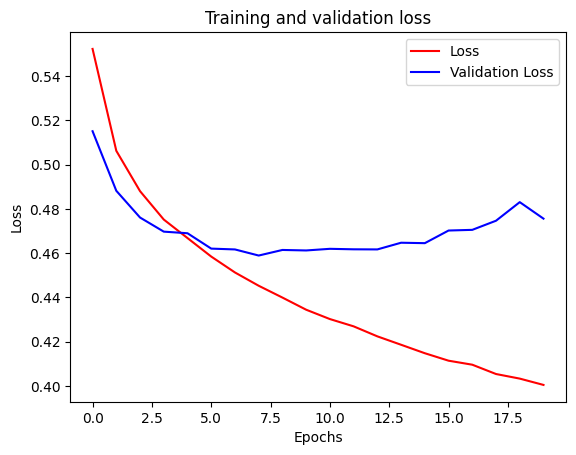

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(20)]

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

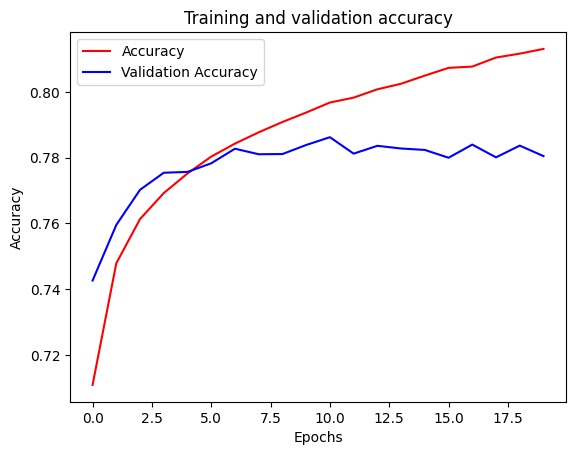

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()